In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft
import numpy as np
import torch
import torch.nn as nn
from clearml import Task, Logger
from sklearn.preprocessing import MinMaxScaler
import copy
import matplotlib.dates as mdates
import seaborn as sns
import ppscore as pps
from autoviz.AutoViz_Class import AutoViz_Class
import logging
import math
import torch.nn.functional as F
from torch.autograd import Variable
import segmentation_models_pytorch as smp
import random

%matplotlib inline

mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)#

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.


In [4]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Linear(vocab_size, d_model) # nn.Embedding(vocab_size, d_model)
    
    def forward(self, x):
        return self.embed(x)


class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 366):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False).to(DEVICE)
        return x

    
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = self.attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        
        # output = self.out(concat)
    
        return concat
    
    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
        #[batch_size, 1, 366, 366]
        if mask is not None:
            mask = mask.unsqueeze(1)
            #print('ATTENTION MASK', mask)
            scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim=-1)
        #print('ATTENTION MASK', scores[0, 0, :, :])
    
        if dropout is not None:
            scores = dropout(scores)

        output = torch.matmul(scores, v)
        return output


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
    
    
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

    
# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        # x = x + self.dropout_2(self.ff(x2))
        return x2
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.01):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()
        
    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
    
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        # [1, 366, INPUT_SIZE]
        x = self.embed(src)
        # [1, 366, d_model]
        x = self.pe(x)
        # [1, 366, d_model]
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)


class Transformer(nn.Module):
    def __init__(self, input_size, output_size, seq_len=366, d_model=32, N=2, heads=1):
        super().__init__()
        self.encoder = Encoder(input_size, d_model, N, heads)
        self.decoder = LSTM(input_size=d_model, output_size=output_size)
        self.d_model = d_model
    
    def reset_hidden_state(self, device):
        self.decoder.reset_hidden_state(device)
        
    def forward(self, src, trg, src_mask=None, trg_mask=None):
        e_outputs = self.encoder(src, src_mask)
        return self.decoder(e_outputs.view(-1, self.d_model))


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=100, num_layers=2, output_size=3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(num_layers, 1, self.hidden_layer_size),
                            torch.zeros(num_layers, 1, self.hidden_layer_size))
    
    def reset_hidden_state(self, device):
        self.hidden_cell = (torch.zeros(self.num_layers, 1, self.hidden_layer_size).to(device),
                            torch.zeros(self.num_layers, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = torch.sigmoid(self.linear(lstm_out.view(len(input_seq), -1)))
        return predictions

In [5]:
### COMMON METHODS ###

def get_refined_weather_station_data_csv_path(place: str, variety: str, year: int, use_engineered_df: bool, group_per_hour: int):
    dir_path = os.path.join(DATA_ROOT, REFINED_WEATHER_STATION_DATA_DIR)
    if use_engineered_df:
        return os.path.join(dir_path, f'{place}_{variety}_eng1_{year}_wsdata_df.csv')
    return os.path.join(dir_path, f'{place}_{variety}_h{group_per_hour}_{year}_wsdata_df.csv')

#--------------------#

def get_model_inout(sequences, input_features, output_features, scaler):
    inout_seq = []
    for i, seq in enumerate(sequences):
        data = torch.FloatTensor(scaler.transform(seq[:, input_features]))
        label = torch.FloatTensor(seq[:, output_features])
        inout_seq.append((data,label))
    return inout_seq

def get_phase_change_dates(phases_array, year):
    phase_change_dates = []
    base_date = datetime.date(year, 1, 1)
    indices_of_phase_change = np.where(phases_array[:-1] != phases_array[1:])[0]
    for index in indices_of_phase_change:
        if not USE_ENGINEERED_DF:
            if GROUP_PER_HOUR==1:
                delta = datetime.timedelta(hours=int(index) + 1)
            else:
                delta = datetime.timedelta(minutes=int(index) * 15 + 15)
        else:
            delta = datetime.timedelta(days=int(index) + 1)
        phase_change_dates.append(base_date + delta)
    return phase_change_dates

# segna il cambio di fase alla prima occorrenza di un valore sopra il threshold per quella fase
def get_phase_change_dates_new(phases_array, year, threshold=0.5):
    # adjust initial predictions to avoid predictions on the 1st day of the year
    phases_array[:30,:] = 0
    phase_change_dates = []
    base_date = datetime.date(year, 1, 1)
    indices_of_phase_change = []
    for phase in range(phases_array.shape[1]):
        try:
            indices_of_phase_change.append(np.where(phases_array[:, phase] > threshold)[0][0])
        except Exception:
            indices_of_phase_change.append(0)
    for index in indices_of_phase_change:
        if not USE_ENGINEERED_DF:
            if GROUP_PER_HOUR > 0:
                delta = datetime.timedelta(hours=GROUP_PER_HOUR * int(index) + GROUP_PER_HOUR)
            else:
                delta = datetime.timedelta(minutes=int(index) * 15 + 15)
        else:
            delta = datetime.timedelta(days=int(index))
        phase_change_dates.append(base_date + delta)
    return phase_change_dates

def plot_graph(y, series, df, year=None, iteration=0, predicted=False, ax=None):
    plt.rc('font', size=12)
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))

    pred_txt = 'predicted' if predicted else 'real'
    # Specify how our lines should look
    if not USE_ENGINEERED_DF:
        step = 96
        if GROUP_PER_HOUR > 1:
            step = int(step / (4 * GROUP_PER_HOUR))
        try:
            ax.plot(df.index[::step], y[::step, 0], label=f'budBreak {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index[::step], y[::step, 1], label=f'flowering {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index[::step], y[::step, 2], label=f'fruitSet {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index[::step], y[::step, 3], label=f'veraison {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index[::step], y[::step, 4], label=f'harvest {pred_txt}')
        except:
            pass
        # ax.plot(df.index[::step], df.iloc[::step, -2]/5000, label='CGDD')
    else:
        try:
            ax.plot(df.index, y[:len(df.index), 0], label=f'budBreak {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index, y[:len(df.index), 1], label=f'flowering {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index, y[:len(df.index), 2], label=f'fruitSet {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index, y[:len(df.index), 3], label=f'veraison {pred_txt}')
        except:
            pass
        try:
            ax.plot(df.index, y[:len(df.index), 4], label=f'harvest {pred_txt}')
        except:
            pass

    # Same as above
    ax.set_xlabel('Time')
    ax.set_ylabel('Phenological Phase probability')
    ax.set_title(series)
    ax.grid(True)
    ax.legend(loc='lower right')
    plt.xticks(rotation=70)
    for index, label in enumerate(ax.xaxis.get_ticklabels()):
        if index % 3 != 0:
            label.set_visible(False)
    if USE_CLEARML:
        logger.report_matplotlib_figure(title=f'Phenological Phases probability - year {year}', series=series, iteration=iteration, figure=fig);
    return ax

def get_num_items_to_ignore(num_days: int = 50):
    if USE_ENGINEERED_DF:
        return num_days
    if GROUP_PER_HOUR > 0:
        return int(num_days * 24 / GROUP_PER_HOUR)
    return int(num_days * 24 * 4)

#FEATURE IMPORTANCE
def feature_importance(model, test_sequences, dfs, years, input_features, output_features, train_sequences):
    loss_function = nn.BCELoss()
    
    train_data = None
    for seq in train_sequences:
        train_data = seq[:, input_features] if train_data is None else np.vstack((train_data, seq[:, input_features]))

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit_transform(train_data)
    
    features_dict = {}
    
    for test_sequence, df, year in zip(test_sequences, dfs, years):
        df = df.iloc[:, input_features]
        test_inout_seq = get_model_inout([test_sequence], input_features=input_features,
                                         output_features=output_features, scaler=scaler)
        single_year_features_dict = {}

        for alteration in ['minimized', 'maximized']:
            for orig_seq, labels in test_inout_seq:
                for current_feature_index in range(orig_seq.size()[1]):
                    with torch.no_grad():
                        seq = copy.deepcopy(orig_seq)
                        seq[:, current_feature_index] = -1 if alteration == 'minimized' else 1
                        seq, labels = seq.to(DEVICE), labels.to(DEVICE)
                        model.reset_hidden_state(DEVICE)

                        y_pred = model(seq)
                        single_loss = loss_function(y_pred, labels)
                        single_year_features_dict[current_feature_index] = single_loss.item()

                    y_pr = y_pred.detach().cpu().numpy()
                    y_real = test_inout_seq[0][1].detach().cpu().numpy()

                    ax = plot_graph(y_real * 0.5, '', df, year)
                    plot_graph(y_pr, f'Predicted Phenological Phases - {df.columns[current_feature_index]} {alteration}', df, year,
                               predicted=True, ax=ax)
        
        features_dict[year] = single_year_features_dict
    print(features_dict)

def get_model_weights_path(place: str, variety: str, train_years: list, use_engineered_df: bool, group_per_hour: int, features: list, uninformed: bool):
    dir_path = os.path.join(DATA_ROOT, MODEL_WEIGHTS_DIR)
    years_str = ''
    for year in train_years:
        years_str += f'{year}_'
    features_str = ''
    if use_engineered_df:
        df_type = 'eng1'
        for feature in features:
            features_str += ENG_DF_FEATURES[feature]
    else:
        df_type = f'h{group_per_hour}'
        for feature in features:
            features_str += H_DF_FEATURES[feature]
    uninformed_sfx = '_un' if uninformed else ''
    return os.path.join(dir_path, f'transformer_lstm_{place}_{variety}_{years_str}{df_type}_{features_str}{uninformed_sfx}.pt')

# Load refined weather station data
def load_datasets():
    dfs_dict = {}
    np_dict = {}

    for year in YEARS:  
        path = get_refined_weather_station_data_csv_path(PLACE, VARIETY, year, USE_ENGINEERED_DF, GROUP_PER_HOUR)
        df = pd.read_csv(path, sep=',', error_bad_lines=False, index_col=0)
        df['phase_change'] = df.loc[:, ['budBreak', 'flowering', 'fruitSet', 'veraison', 'harvest']].sum(axis=1)
        df.loc[df['phase_change'] < 2, 'phase_change'] = 0
        df.loc[df['phase_change'] > 0, 'phase_change'] = 1
        df.loc[df['budBreak'].idxmax(), 'phase_change'] = 1
        dfs_dict[year] = df
        np_dict[year] = df.to_numpy()
    return dfs_dict, np_dict

# Load AI model
def get_model(load_model: bool, model_weights_path: str = None):
    model = Transformer(input_size=len(INPUT_FEATURES), output_size=len(OUTPUT_FEATURES), seq_len=366, d_model=36, # len(INPUT_FEATURES) + (len(INPUT_FEATURES)%2),
                        N=TRANSFORMER_N, heads=TRANSFORMER_HEADS).to(DEVICE)
    if load_model:
        path = model_weights_path if model_weights_path else WEIGHTS_PATH
        if os.path.exists(path):
            model.load_state_dict(torch.load(path), strict=False)
            print(f'Model {path} loaded')
        else:
            print(f'MISSING: Model {path} not found, weights initialized randomly')
    else:
        print(f'Creating new model with weights initialized randomly')
    return model

def run_train(epochs: int, lrs: list, load_model: bool = True, save_model: bool = True, uninformed: bool = False):
    model = get_model(load_model)
    _, np_dict = load_datasets()
    train_on = [np_dict[year] for year in TRAIN_YEARS]
    return train(model, train_on, input_features=INPUT_FEATURES, output_features=OUTPUT_FEATURES, epochs=epochs, lrs=lrs, save_model=save_model, uninformed=uninformed)

def run_test(model=None, starting_day=0, just_last_prediction=False, uninformed=False):
    if model is None:
        model = get_model(True)
        
    dfs_dict, np_dict = load_datasets()
    train_on = [np_dict[year] for year in TRAIN_YEARS]
    test_on = [np_dict[year] for year in YEARS]
    dfs = [dfs_dict[year] for year in YEARS]
    return test(model, test_on, dfs, YEARS, input_features=INPUT_FEATURES, output_features=OUTPUT_FEATURES, train_sequences=train_on, starting_day=starting_day,
                just_last_prediction=just_last_prediction, uninformed=uninformed)

def run_feature_importance(year_index: int = -1):
    model = get_model(True)
    dfs_dict, np_dict = load_datasets()
    train_on = [np_dict[year] for year in TRAIN_YEARS]
    test_on = [np_dict[YEARS[year_index]]]
    dfs = [dfs_dict[YEARS[year_index]]]
    years = [YEARS[year_index]]
    feature_importance(model, test_on, dfs, years, input_features=INPUT_FEATURES, output_features=OUTPUT_FEATURES, train_sequences=train_on)

def plot_statistics():
    dfs_dict, np_dict = load_datasets()
    dfs = [dfs_dict[year] for year in YEARS]
    df_complete = None
    for df in dfs:
        if df_complete is None:
            df_complete = df
        else:
            df_complete.append(df)
    df_complete.loc[df_complete.budBreak == 0.25, 'budBreak'] = 0
    df_complete.loc[df_complete.flowering == 0.25, 'flowering'] = 0
    df_complete.loc[df_complete.fruitSet == 0.25, 'fruitSet'] = 0
    df_complete.loc[df_complete.veraison == 0.25, 'veraison'] = 0
    df_complete.loc[df_complete.harvest == 0.25, 'harvest'] = 0

    # HEATMAP
    plt.figure(figsize=(16,12))
    sns.heatmap(df_complete.corr(),annot=True,fmt=".2f")
    plt.show()

    # PREDICTIVE POWER SCORE
    plt.figure(figsize=(16,12))
    matrix_df = pps.matrix(df_complete)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    sns.heatmap(matrix_df, fmt=".2f", annot=True)
    plt.show()

    # AUTOVIZ
    Av = AutoViz_Class()
    sep=' ' # Separators are used in dataset
    target='veraison' # pickup any column for testing only
    dfv= Av.AutoViz('', sep=sep, depVar=target, dfte=df_complete, lowess=False, chart_format='svg')

    # VALUES PLOT
    values = df_complete.values
    groups = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12] # specify columns to plot
    i = 1
    # plot each column
    plt.figure(figsize=(16,48))
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df_complete.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()

def nopeak_mask(size):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8') # k=-30 rende il modello "cieco" al valore dell'output degli ultimi 30 valori (giorni)
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    return np_mask

def create_masks(src, trg, pad=-2): # Magheggione dell' and bit a bit
    #src_mask = (src != pad).unsqueeze(-2).to(DEVICE)
    #size = src.size(1) # get seq_len for matrix
    #np_mask = Variable(torch.from_numpy(np.ones((1, size, size)).astype('uint8')) == 1).to(DEVICE)
    #src_mask = src_mask & src_mask.transpose(1,2) & np_mask
    if src is not None:
        src_mask = (src != pad).unsqueeze(-2)
        size = src.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size).to(DEVICE)
        src_mask = src_mask & src_mask.transpose(1,2) & np_mask
        src_mask[0, :, 0] = True
    else:
        src_mask = None

    if trg is not None:
        trg_mask = (trg != pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size).to(DEVICE)
        trg_mask = trg_mask & trg_mask.transpose(1,2) & np_mask
        trg_mask[0, :, 0] = True
    else:
        trg_mask = None
    return src_mask[:1, ...], trg_mask[:1, ...]


# TRAIN
def train(model, train_sequences, input_features, output_features, epochs=1000, lrs=[1e-3], save_model=True, uninformed=False):
    # if uninformed == True -> src_input = all input, trg_input = empty (just padding)
    mu, sigma = 0, 0.1
    loss_function = nn.BCELoss() # smp.utils.losses.DiceLoss()
    model.train()
    
    train_data = None
    for seq in train_sequences:
        train_data = seq[:, input_features] if train_data is None else np.vstack((train_data, seq[:, input_features]))

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit_transform(train_data)
    # Used to facilitate training, reducing the impact of the hidden state initialization
    ignore_first_n_items = get_num_items_to_ignore()
    
    train_inout_seq = get_model_inout(train_sequences, input_features=input_features,
                                      output_features=output_features, scaler=scaler)
    
    for lr in lrs:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        for i in range(epochs):
            mean_loss, k = 0, 0
            j_range = [366 - 1] if uninformed else range(50, 250)
            for j in j_range:
                for src, trg in train_inout_seq:
                    targets = F.pad(trg, (0, 0, 0, 366 - trg.size(0)), 'constant', -2).to(DEVICE)
                    src_input = F.pad(src[:j+1, :], (0, 0, 0, 366 - src[:j+1, :].size(0)), 'constant', -2)
                    src_input = src_input + np.random.normal(mu, sigma, src_input.size()).astype(np.float32) # Add noise
                    src_input = src_input.unsqueeze(0).to(DEVICE)
                    trg_input = F.pad(trg[:0 if uninformed else j, :], (0, 0, 0, 366 - trg[:0 if uninformed else j, :].size(0)), 'constant', -2)
                    trg_input = trg_input.unsqueeze(0).to(DEVICE)
                    src_mask, trg_mask = create_masks(src_input.squeeze(0).transpose(0,1), trg_input.squeeze(0).transpose(0,1))
                    optimizer.zero_grad()
                    model.reset_hidden_state(DEVICE)
                    y_pred = model(src_input, trg_input, src_mask=src_mask, trg_mask=trg_mask)
                    loss = loss_function(y_pred.squeeze(0)[:j, :], targets[:j, :])
                    if uninformed:
                        idx = (targets > 0).nonzero(as_tuple=True)
                        loss += loss_function(y_pred.squeeze(0)[idx], targets[idx])
                    else:
                        loss += loss_function(y_pred.squeeze(0)[j, :], targets[j, :])
                    loss.backward()
                    optimizer.step()
                    if not math.isnan(loss.item()):
                        mean_loss = (mean_loss * k + loss.item()) / (k + 1)
                        k +=1

            '''
            for i in range(epochs):
            mean_loss, k = 0, 0
            for src, trg in train_inout_seq:
                targets = F.pad(trg, (0, 0, 0, 366 - trg.size(0)), 'constant', -2).to(DEVICE)
                for j in range(0, 366):
                    src_input = F.pad(src, (0, 0, 0, 366 - src.size(0)), 'constant', -2)
                    src_input = src_input.unsqueeze(0).to(DEVICE)
                    trg_input = F.pad(trg[:j, :], (0, 0, 0, 366 - trg[:j, :].size(0)), 'constant', -2)
                    trg_input = trg_input.unsqueeze(0).to(DEVICE)
                    src_mask, trg_mask = create_masks(src_input.squeeze(0).transpose(0,1), trg_input.squeeze(0).transpose(0,1))
                    optimizer.zero_grad()
                    y_pred = model(src_input, trg_input, src_mask=src_mask, trg_mask=trg_mask)
                    single_loss = loss_function(y_pred.squeeze(0)[:trg.size(0), :], targets[:trg.size(0), :])
                    if not math.isnan(single_loss.item()):
                        mean_loss = (mean_loss * k + single_loss.item()) / (k + 1)
                        k +=1
                    single_loss.backward()
                    optimizer.step()
                    with torch.no_grad():
                        trg[i, :] = y_pred.squeeze(0)[i, :].to(DEVICE)
            '''

            if (i+1)%50 == 0:
                print(f'epoch: {(i+1):3}\tloss: {mean_loss:10.8f}\tlr: {lr}')
                if save_model:
                    torch.save(model.state_dict(), WEIGHTS_PATH)
    
    if save_model:
        torch.save(model.state_dict(), WEIGHTS_PATH)
    return model

# TEST
def test(model, test_sequences, dfs, years, input_features, output_features, train_sequences, starting_day=0, just_last_prediction=False, uninformed=False):
    loss_function = nn.BCELoss()
    composed_comparison_df = None
    
    train_data = None
    for seq in train_sequences:
        train_data = seq[:, input_features] if train_data is None else np.vstack((train_data, seq[:, input_features]))

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit_transform(train_data)
    print('features_min:', scaler.data_min_, 'features_max:', scaler.data_max_)

    # Used to facilitate training, reducing the impact of the hidden state initialization
    ignore_first_n_items = get_num_items_to_ignore()
    model.eval()
    for test_sequence, df, year in zip(test_sequences, dfs, years):
        test_inout_seq = get_model_inout([test_sequence], input_features=input_features,
                                         output_features=output_features, scaler=scaler)
        for src, trg in test_inout_seq:
            y_pr = np.zeros((366, len(output_features)))
            y_pr[:starting_day, :] = trg[:starting_day, :]
            with torch.no_grad():
                if uninformed:
                    trg_input = F.pad(trg[:0, :], (0, 0, 0, 366 - trg[:0, :].size(0)), 'constant', -2).to(DEVICE)
                    trg_input = trg_input.unsqueeze(0)
                    src_input = F.pad(src, (0, 0, 0, 366 - src.size(0)), 'constant', -2)
                    src_input = src_input.unsqueeze(0).to(DEVICE)
                    src_mask, trg_mask = create_masks(src_input.squeeze(0).transpose(0,1), trg_input.squeeze(0).transpose(0,1))
                    model.reset_hidden_state(DEVICE)
                    y_pred = model(src_input, trg_input, src_mask=src_mask, trg_mask=trg_mask)
                else:
                    trg_input = F.pad(trg[:starting_day, :], (0, 0, 0, 366 - trg[:starting_day, :].size(0)), 'constant', -2).to(DEVICE)
                    trg_input = trg_input.unsqueeze(0).to(DEVICE)
                    for i in range(starting_day, 366):
                        src_input = F.pad(src[:i+1, :], (0, 0, 0, 366 - src[:i+1, :].size(0)), 'constant', -2)
                        src_input = src_input.unsqueeze(0).to(DEVICE)
                        # trg_input = F.pad(trg[:i, :], (0, 0, 0, 366 - trg[:i, :].size(0)), 'constant', -2).to(DEVICE)
                        # trg_input = trg_input.unsqueeze(0)

                        src_mask, trg_mask = create_masks(src_input.squeeze(0).transpose(0,1), trg_input.squeeze(0).transpose(0,1))

                        model.reset_hidden_state(DEVICE)
                        y_pred = model(src_input, trg_input, src_mask=src_mask, trg_mask=trg_mask)
                        
                        if i >= 200 and i < 205:
                            #print('I', i, 'SRC', src_input[0, 200:205, :], 'TRG IN', trg_input[0, 200:205, :], 'PRED', y_pred[0, 200:205+1, :], 'TRG', trg[200:205+1, :])
                            pass

                        # single_loss = loss_function(y_pred.squeeze(0)[:trg.size(0), :], trg.to(DEVICE))
                        trg_input[0, i, :] = y_pred.squeeze(0)[i, :].to(DEVICE)
                        if i >= 200 and i < 205:
                            #print('I', i, 'TRG IN NEW', trg_input[0, 200:205, :])
                            pass
                        last_pred = y_pred.squeeze(0).detach().cpu().numpy()[i, :]
                        # Make the prediction "binary" to have the input look more similar to the one in the training
                        # last_pred[last_pred < 0.5] = 0.0
                        # last_pred[last_pred >= 0.5] = 1.0
                        y_pr[i, :] = last_pred

        if just_last_prediction or uninformed:
            y_pr = y_pred.squeeze(0).detach().cpu().numpy()
        y_pr[:ignore_first_n_items] = 0.0
        y_real = test_inout_seq[0][1].detach().cpu().numpy()
        predicted_phase = np.argmax(y_pr, axis=1)
        actual_phase = np.argmax(y_real, axis=1)

        ax = plot_graph(y_real * 0.5, '', df, year)
        plot_graph(y_pr, f'Predicted vs Real Phenological Phases', df, year, predicted=True, ax=ax)

        try:
            prediction_df = pd.DataFrame(get_phase_change_dates_new(y_pr, year=year), columns=['predicted date'])
            actual_df = pd.DataFrame(get_phase_change_dates_new(y_real, year=year), columns=['actual date'])
            comparison_df = pd.concat([prediction_df, actual_df], axis=1)
            idx = pd.Index(['budBreak', 'flowering', 'fruitSet', 'veraison', 'harvest'])
            comparison_df.index = pd.Index(idx[np.array(OUTPUT_FEATURES) - 12])
            comparison_df['error[days]'] = (comparison_df['predicted date'] - comparison_df['actual date']).astype('timedelta64[D]')
            if USE_CLEARML:
                logger.report_table("Inference table", f'year {year}', iteration=0, table_plot=comparison_df)
            if composed_comparison_df is None:
                composed_comparison_df = comparison_df
            else:
                composed_comparison_df = composed_comparison_df.append(comparison_df)
        except Exception as e:
            raise e
            pass
    return composed_comparison_df


In [6]:
# Performance scale: :'( --> :( --> :| --> :) --> :D

# TRANSFORMER LSTM
# d_model = 36 | TRANSFORMER_N = 3 | TRANSFORMER_HEADS = 6 | hidden_layer_size = 100 | num_layers = 2

# SYMINGTON ATAIDE #

    # - TOURIGA NACIONAL - #

        # - - ENG1 - - #
        
            # - - - IN [0, 1, 2] - OUT [12, 13, 15] - - - # temp
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2018_2019_eng1_t_un.pt 27 5 11 21 :(
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2018_2020_eng1_t_un.pt 14 10 15 1 :|
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2019_2020_eng1_t_un.pt 0 -4 -12 11 :)
                # transformer_lstm_symington_ataide_touriga_nacional_2018_2019_2020_eng1_t_un.pt -1 -14 -14 1 :(
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2018_2019_2020_eng1_t_un.pt 20 :(
                
            
            # - - - IN [0, 1, 2, 9, 11] - OUT [12, 13, 15] - - - # temp + radiation
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2018_2019_eng1_tr_un.pt 18 21 14 20 :(
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2018_2020_eng1_tr_un.pt -17 -7 -3 9 :(
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2019_2020_eng1_tr_un.pt -12 -3 -12 10 :)
                # transformer_lstm_symington_ataide_touriga_nacional_2018_2019_2020_eng1_tr_un.pt 1 -3 -24 14 :(
                # transformer_lstm_symington_ataide_touriga_nacional_2017_2018_2019_2020_eng1_tr_un.pt 13 :|

    # - TOURIGA FRANCA - #

        # - - ENG1 - - #

            # - - - IN [0, 1, 2] - OUT [12, 13, 15] - - - # temp
                # transformer_lstm_symington_ataide_touriga_franca_2017_2018_2019_eng1_t_un.pt 14 5 9 20 :(
                # transformer_lstm_symington_ataide_touriga_franca_2017_2018_2020_eng1_t_un.pt 5 10 12 6 :)
                # transformer_lstm_symington_ataide_touriga_franca_2017_2019_2020_eng1_t_un.pt -53 -10 -8 8 :'(
                # transformer_lstm_symington_ataide_touriga_franca_2018_2019_2020_eng1_t_un.pt -5 -18 -16 1 :(
                # transformer_lstm_symington_ataide_touriga_franca_2017_2018_2019_2020_eng1_t_un.pt 0 :D

            # - - - IN [0, 1, 2, 9, 11] - OUT [12, 13, 15] - - - # temp + humidity + radiation
                # transformer_lstm_symington_ataide_touriga_franca_2017_2018_2019_eng1_tr_un.pt 13 10 14 17 :(
                # transformer_lstm_symington_ataide_touriga_franca_2017_2019_2020_eng1_tr_un.pt -12 -3 -8 7 :)
                # transformer_lstm_symington_ataide_touriga_franca_2017_2018_2020_eng1_tr_un.pt -18 0 8 3 :|
                # transformer_lstm_symington_ataide_touriga_franca_2018_2019_2020_eng1_tr_un.pt -8 -1 -20 2 :|
                # transformer_lstm_symington_ataide_touriga_franca_2017_2018_2019_2020_eng1_tr_un.pt 7 :D

        
# TORRES - ARANYO' #

    # - SYRAH - #

        # - - ENG1 - - #
            
            # - - - IN [0, 1, 2] - OUT [12, 13, 14, 15, 16] - - - # temp
                # transformer_lstm_torres_agrolab_2017_2018_2019_eng1_t_un.pt 0 1 4 -7 -6 ?BAD 2021? :) or :|
                # transformer_lstm_torres_agrolab_2017_2018_2020_eng1_t_un.pt -19 3 3 0 -8 :|
                # transformer_lstm_torres_agrolab_2017_2019_2020_eng1_t_un.pt 0 8 9 21 0 :|
                # transformer_lstm_torres_agrolab_2018_2019_2020_eng1_t_un.pt -1 -11 -14 -33 -1 :'(
                # transformer_lstm_torres_agrolab_2017_2018_2019_2020_eng1_t_un.pt ? no data for 2021
            
            # - - - IN [0, 1, 2, 9, 11] - OUT [12, 13, 14, 15, 16] - - - # temp + radiation
                # transformer_lstm_torres_agrolab_2017_2018_2019_eng1_tr_un.pt 12 4 6 -2 -4 :D
                # transformer_lstm_torres_agrolab_2017_2018_2020_eng1_tr_un.pt -25 3 4 -9 -13 :(
                # transformer_lstm_torres_agrolab_2017_2019_2020_eng1_tr_un.pt -1 8 8 24 -2 :|
                # transformer_lstm_torres_agrolab_2018_2019_2020_eng1_tr_un.pt -1 -10 -10 -26 -9 :|
                # transformer_lstm_torres_agrolab_2017_2018_2019_2020_eng1_tr_un.pt ? no data for 2021
                

# MASTROBERARDINO #

    # - AGLIANICO - #

        # - - ENG1 - - #
            
            # - - - IN [0, 1, 2] - OUT [12, 13, 14, 15, 16] - - - # temp
                # transformer_lstm_mastroberardino_aglianico_2017_2018_2020_eng1_t_un.pt 3 2 9 0 1 :D

In [7]:
### Variable parameters ###

DATA_ROOT = '/mnt/data2/angioletti_data/vitigeoss'
REFINED_WEATHER_STATION_DATA_DIR = 'refined_weather_station_data'
MODEL_WEIGHTS_DIR = 'model_weights'
DEVICE = 'cuda:1'
PLACE = 'symington_ataide'
VARIETY_INDEX = 1
YEARS = [2017, 2018, 2019, 2020, 2021]
TRAIN_YEARS = [2017, 2018, 2019, 2020]
UNINFORMED = True
USE_ENGINEERED_DF = True
GROUP_PER_HOUR = 3
TRANSFORMER_N = 3
TRANSFORMER_HEADS = 6
# ENG DF (temp, temp_min, temp_max, humidity, humidity_min, humidity_max, rain, rain_min, rain_max,
#         radiation, radiation_min, radiation_max, budBreak, flowering, fruitSet, veraison, harvest)

# H DF (temp, humidity, rain, winddirection, wind, radiation, eto, budBreak, flowering, fruitSet,
#       veraison, harvest, GDD, CGDD, CIRR)
INPUT_FEATURES = [0, 1, 2]
OUTPUT_FEATURES = [12, 13, 14, 15, 16]

### Fixed parameters ###
ENG_DF_FEATURES = ('t', '', '', 'h', '', '', 'R', '', '', 'r', '', '', 'BB', 'F', 'FS', 'V', 'H')
H_DF_FEATURES = ('t', 'h', 'R', 'W', 'w', 'r', 'e', 'BB', 'F', 'FS', 'V', 'H', 'GDD', 'CGDD', 'CIRR')

PLACE_TO_VARIETIES = {
    'mastroberardino': ['aglianico'],
    'symington_ataide': ['touriga_nacional', 'touriga_franca'],
    'torres': ['agrolab']
}
VARIETY = PLACE_TO_VARIETIES[PLACE][VARIETY_INDEX]

PLACE_TO_STATION = {
    'mastroberardino': 'mirabella',
    'symington_ataide': 'vilarica',
    'torres': 'les-borges-blances'
}

WEIGHTS_PATH = get_model_weights_path(PLACE, VARIETY, TRAIN_YEARS, USE_ENGINEERED_DF, GROUP_PER_HOUR, INPUT_FEATURES, UNINFORMED)
print(WEIGHTS_PATH)

# CLEARML
USE_CLEARML = False
CLEARML_PROJECT_NAME = f'Vitigeoss {PLACE}'
SNAPSHTOS_PATH = '/mnt/data2/angioletti_data/clearml_snapshots'
CLEARML_TASK_NAME = ''
if USE_CLEARML:
    task = Task.init(project_name=CLEARML_PROJECT_NAME, task_name=CLEARML_TASK_NAME, output_uri=SNAPSHTOS_PATH)
    logger = Logger.current_logger()

/mnt/data2/angioletti_data/vitigeoss/model_weights/transformer_lstm_symington_ataide_touriga_franca_2017_2018_2019_2020_eng1_t_un.pt


In [35]:
model = run_train(epochs=150, lrs=[1e-4], load_model=True, save_model=True, uninformed=UNINFORMED)

Model /mnt/data2/angioletti_data/vitigeoss/model_weights/transformer_lstm_symington_ataide_touriga_franca_2017_2018_2019_2020_eng1_t_un.pt loaded
epoch:  50	loss: 0.01681219	lr: 0.0001
epoch: 100	loss: 0.01555336	lr: 0.0001
epoch: 150	loss: 0.00854807	lr: 0.0001


In [8]:
#test_model = get_model(load_model=True, model_weights_path='/mnt/data2/angioletti_data/vitigeoss/model_weights/torres_agrolab_2017_2018_2019_eng1_t.pt')
test_model = None

results_df = run_test(model=test_model, starting_day=0, just_last_prediction=True, uninformed=True)
results_df

Model /mnt/data2/angioletti_data/vitigeoss/model_weights/transformer_lstm_symington_ataide_touriga_franca_2017_2018_2019_2020_eng1_t_un.pt loaded
features_min: [-1.26145833 -4.74       -0.035     ] features_max: [33.328125 25.77     43.275   ]


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

Model /mnt/data2/angioletti_data/vitigeoss/model_weights/transformer_lstm_symington_ataide_touriga_nacional_2018_2019_2020_eng1_t_un.pt loaded


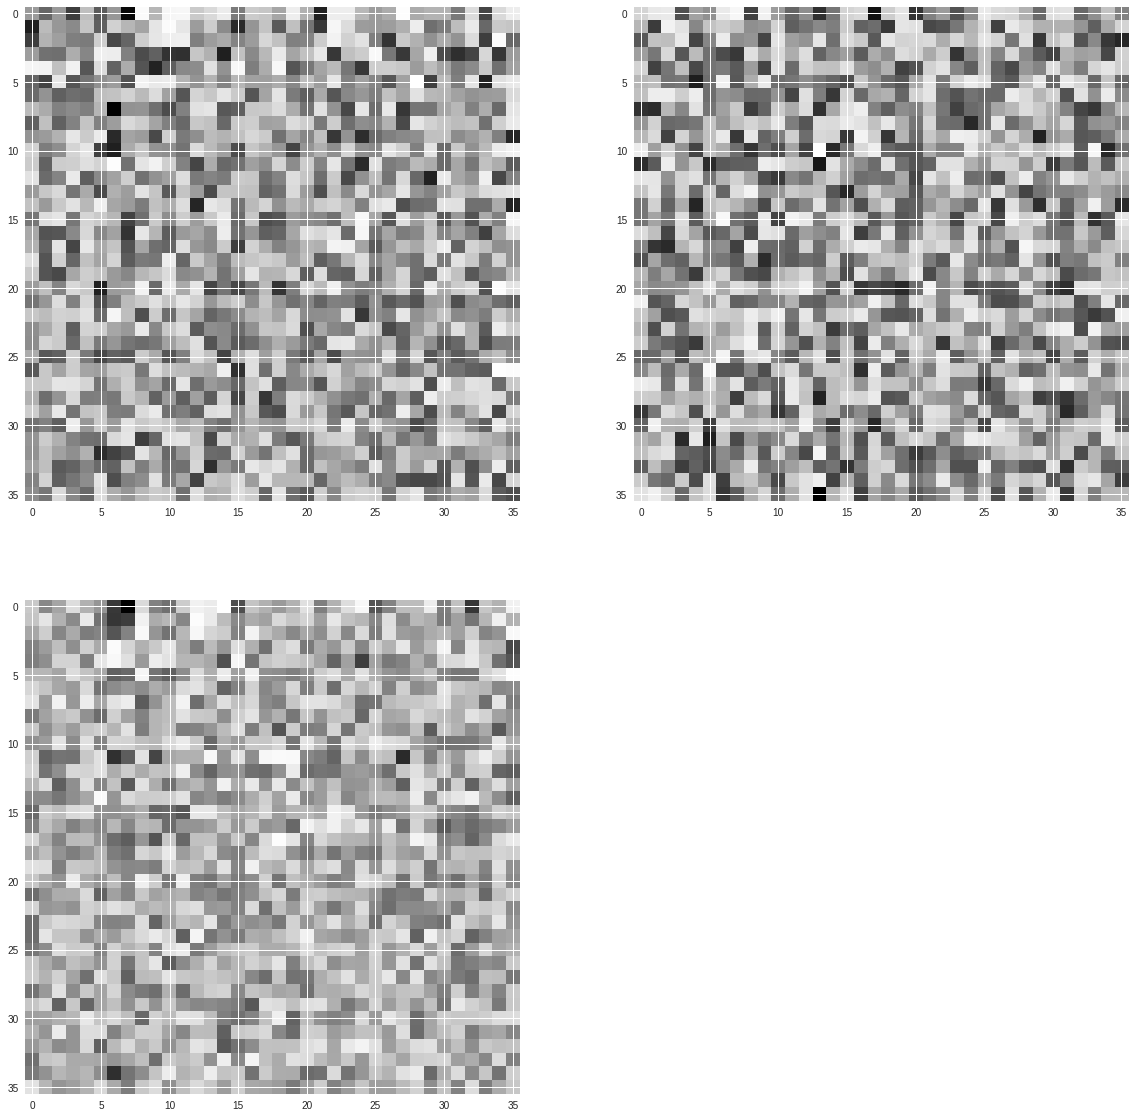

In [58]:
from matplotlib import pyplot as plt
model = get_model(True)
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(model.state_dict()['encoder.layers.0.attn.q_linear.weight'].cpu().numpy())
ax1 = fig.add_subplot(2,2,2)
ax1.imshow(model.state_dict()['encoder.layers.0.attn.v_linear.weight'].cpu().numpy())
ax1 = fig.add_subplot(2,2,3)
ax1.imshow(model.state_dict()['encoder.layers.0.attn.k_linear.weight'].cpu().numpy())

In [57]:
model.state_dict().keys()

odict_keys(['encoder.embed.embed.weight', 'encoder.embed.embed.bias', 'encoder.pe.pe', 'encoder.layers.0.norm_1.alpha', 'encoder.layers.0.norm_1.bias', 'encoder.layers.0.norm_2.alpha', 'encoder.layers.0.norm_2.bias', 'encoder.layers.0.attn.q_linear.weight', 'encoder.layers.0.attn.q_linear.bias', 'encoder.layers.0.attn.v_linear.weight', 'encoder.layers.0.attn.v_linear.bias', 'encoder.layers.0.attn.k_linear.weight', 'encoder.layers.0.attn.k_linear.bias', 'encoder.layers.0.attn.out.weight', 'encoder.layers.0.attn.out.bias', 'encoder.layers.0.ff.linear_1.weight', 'encoder.layers.0.ff.linear_1.bias', 'encoder.layers.0.ff.linear_2.weight', 'encoder.layers.0.ff.linear_2.bias', 'encoder.layers.1.norm_1.alpha', 'encoder.layers.1.norm_1.bias', 'encoder.layers.1.norm_2.alpha', 'encoder.layers.1.norm_2.bias', 'encoder.layers.1.attn.q_linear.weight', 'encoder.layers.1.attn.q_linear.bias', 'encoder.layers.1.attn.v_linear.weight', 'encoder.layers.1.attn.v_linear.bias', 'encoder.layers.1.attn.k_linear

In [213]:
#a = torch.from_numpy(np.array([[[True, False, False], [True, True, False], [True, True, True]]]))
#b = torch.from_numpy(np.array([[[True, True, False]]]))
#print(a.shape, b.shape, b.transpose(1,2).shape)
#(b & a & b.transpose(1,2))

Text(0.5, 0.98, 'Additive Decompose')

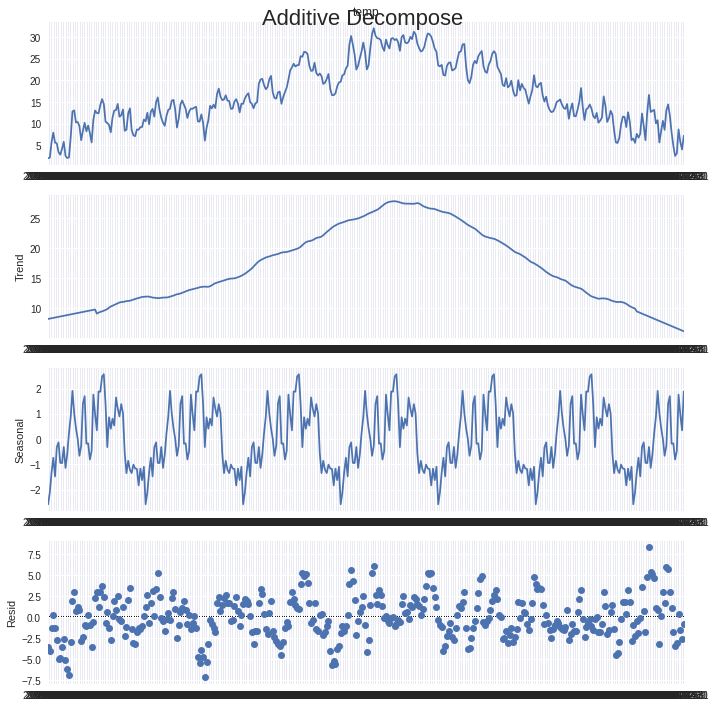

In [122]:
from statsmodels.tsa.seasonal import seasonal_decompose
dfs_dict, np_dict = load_datasets()
df = dfs_dict[2020]
#result_mul = seasonal_decompose(df['temp'], model='multiplicative', extrapolate_trend='freq', period=1)
result_add = seasonal_decompose(df['temp'], model='additive', extrapolate_trend='freq', period=56)
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
#plt.show()

Text(0.5, 0.98, 'Additive Decompose')

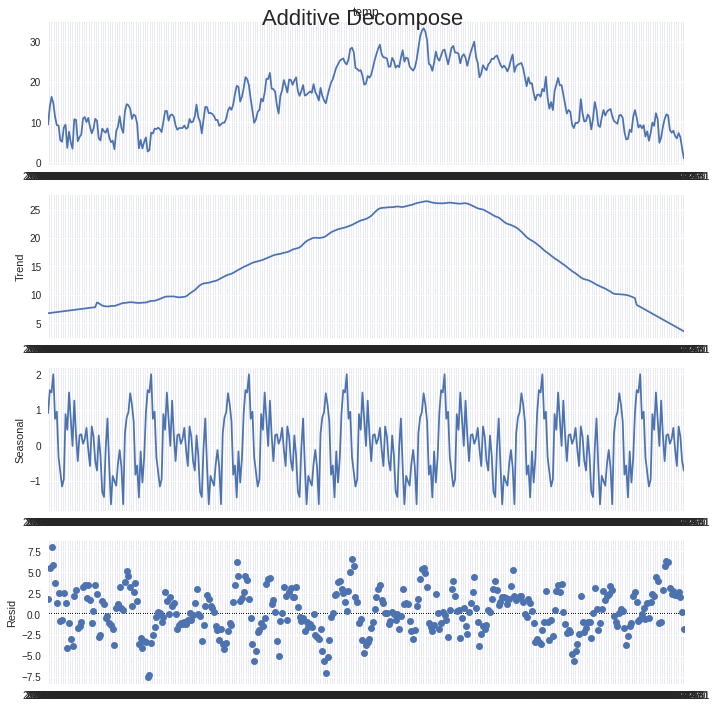

In [123]:
df = dfs_dict[2018]
result_add = seasonal_decompose(df['temp'], model='additive', extrapolate_trend='freq', period=56)
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
#plt.show()

In [ ]:
if USE_CLEARML:
    task.close()